# Experiment Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity
import seaborn as sns
import json
from models.models import NeuralScoreLR

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_log_lr_cost(data, score_col, ss0=False): 

    if score_col == "count_lr":
        lr_same = np.exp(data[score_col][data['same_source']])
        lr_diff = np.exp(data[score_col][~data['same_source']])
        return 0.5 * np.mean(np.log2(1 + 1/(lr_same))) + \
            0.5 * np.mean(np.log2(1 + lr_diff))
    elif ss0: # lrs will be on the natural log scale; handles numerical underflow for same source lrs
        lr_diff = np.exp(data[score_col][~data['same_source']])
        lnlr_same = data[score_col][data['same_source']]
        # log2(1 + 1/LR) = log2([LR+1]/LR) = log2(LR+1) - log2(LR) = log2(LR+1) - [ln(LR)/ln(2)]
        return 0.5 * np.mean((np.log2(np.exp(lnlr_same) + 1)) - (lnlr_same/np.log(2))) + \
            0.5 * np.mean(np.log2(1 + lr_diff))
    else:
        lr_same = data[score_col][data['same_source']]
        lr_diff = data[score_col][~data['same_source']]
        
        return 0.5 * np.mean(np.log2(1 + 1/(lr_same))) + \
            0.5 * np.mean(np.log2(1 + lr_diff))

In [3]:
def get_metrics_for_dataset(dataset, n_rep):
    test_files = ['./results/' + dataset + '_test' + str(i) + '.csv' for i in range(n_rep)]

    # store results
    results_df_list = []

    methods = [
        "luar_avg_lr",
        "luar_tru_lr",
        "luar_win_lr",
        "cisr_tru_lr",
        "cisr_avg_lr",
        "znorm_lr",
        "lex_lr",
        "count_lr" # this is on ln scale; doesn't matter for auc, adjusted for cllr
    ]

    for j in range(n_rep):
        lr_results = pd.read_csv(test_files[j])

        results_df_list.append(
            pd.DataFrame(
                {
                    "Method": methods,
                    "Run": [j]*len(methods),
                    "Category": ["embedding"]*5+["manual"]*3, # matches methods list order
                    "AUC": [roc_auc_score(lr_results.same_source, lr_results[m].tolist()) for m in methods],
                    "Cllr": [calc_log_lr_cost(lr_results, m) for m in methods]
                }
            )
        )

    return pd.concat(results_df_list)

In [4]:
dr = get_metrics_for_dataset("darkreddit", 15)
sr = get_metrics_for_dataset("silkroad", 15)
ag = get_metrics_for_dataset("agora", 15)
am = get_metrics_for_dataset("amazon", 15)

### Results Processing

In [5]:
# numerical underflow in amazon dataset gives some infinite Cllrs
am.describe()
# others look fine - see below

,Run,AUC,Cllr
count,120.000000,120.000000,120.000000
mean,7.000000,0.864677,inf
std,4.338609,0.066246,NaN
min,0.000000,0.704432,0.342916
25%,3.000000,0.828512,0.544893
50%,7.000000,0.870320,0.703621
75%,11.000000,0.912744,0.869643
max,14.000000,0.967408,inf


In [6]:
dr.describe()

,Run,AUC,Cllr
count,120.000000,120.000000,120.000000
mean,7.000000,0.744779,0.900320
std,4.338609,0.110544,0.279702
min,0.000000,0.538720,0.629757
25%,3.000000,0.621292,0.738393
50%,7.000000,0.797480,0.786962
75%,11.000000,0.829516,0.969958
max,14.000000,0.879664,1.832167


In [7]:
sr.describe()

,Run,AUC,Cllr
count,120.000000,120.000000,120.000000
mean,7.000000,0.703167,1.022239
std,4.338609,0.083328,0.395604
min,0.000000,0.526720,0.752138
25%,3.000000,0.619892,0.816319
50%,7.000000,0.735400,0.871825
75%,11.000000,0.773144,0.983391
max,14.000000,0.821680,2.279856


In [8]:
ag.describe()

,Run,AUC,Cllr
count,120.000000,120.000000,120.000000
mean,7.000000,0.720074,1.005852
std,4.338609,0.081582,0.384544
min,0.000000,0.534352,0.746705
25%,3.000000,0.652972,0.816302
50%,7.000000,0.746528,0.867202
75%,11.000000,0.782824,0.981756
max,14.000000,0.830896,2.871116


In [9]:
# method is CISR with average embeddings in runs 12 and 13
am.loc[am["Cllr"] == np.inf,:]

,Method,Run,Category,AUC,Cllr
4,cisr_avg_lr,12,embedding,0.877760,inf
4,cisr_avg_lr,13,embedding,0.890352,inf


In [10]:
am_run12 = pd.read_csv('./results/amazon_test12.csv')
am_run13 = pd.read_csv('./results/amazon_test13.csv')

In [11]:
# problem is a same source LR = 0 (divide by 0 in cllr)
am_run12.loc[am_run12.same_source, :].describe()

,problem_id,luar_avg_lr,luar_tru_lr,luar_win_lr,cisr_avg_lr,cisr_tru_lr,znorm_lr,lex_lr,count_lr
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000,250.000000
mean,3023.348000,94.639509,38.648572,11.536330,5.462559,3.244750,1.247373e+24,1.820616,-9.413719
std,1792.464916,708.431092,142.051252,14.590451,3.783619,2.018039,1.972249e+25,1.345254,15.945288
min,39.000000,0.000123,0.001912,0.003077,0.000000,0.016033,8.698946e-02,0.213244,-60.694499
25%,1336.000000,4.125691,1.835511,1.082335,1.796664,1.477067,1.065124e+00,0.951420,-19.530302
50%,3021.000000,21.212543,9.381141,3.072036,5.537817,2.868677,1.929512e+00,1.400192,-7.778396
75%,4482.500000,37.836569,33.148442,21.955408,8.992781,5.330529,5.980947e+00,2.302580,0.997660
max,6241.000000,11001.384185,1664.236168,43.804075,10.794375,6.164714,3.118400e+26,5.891699,26.401954


In [12]:
# diff source looks okay
am_run12.loc[~am_run12.same_source, :].describe()

,problem_id,luar_avg_lr,luar_tru_lr,luar_win_lr,cisr_avg_lr,cisr_tru_lr,znorm_lr,lex_lr,count_lr
count,250.000000,2.500000e+02,2.500000e+02,2.500000e+02,250.000000,2.500000e+02,250.000000,250.000000,250.000000
mean,9431.520000,3.351526e-01,4.481429e-01,6.772418e-01,1.039792,1.084260e+00,0.847647,0.949492,-32.445384
std,1799.693192,9.589609e-01,9.774775e-01,1.438154e+00,2.191026,1.580486e+00,1.296559,0.760553,16.401392
min,6314.000000,6.059058e-54,1.058220e-08,8.036041e-82,0.000000,5.060097e-89,0.044667,0.140757,-90.407071
25%,7865.750000,1.742019e-02,4.024503e-02,6.101724e-02,0.030414,8.868786e-02,0.187136,0.403340,-42.081254
50%,9580.500000,5.291650e-02,1.293592e-01,1.755172e-01,0.203631,2.474858e-01,0.400195,0.744374,-30.963901
75%,10924.000000,2.073674e-01,3.985975e-01,5.668868e-01,0.879010,1.273685e+00,0.918542,1.199081,-20.973035
max,12601.000000,1.137276e+01,9.648947e+00,1.324094e+01,10.795277,6.141386e+00,9.535451,4.513415,3.203836


In [13]:
# same with run 13
am_run13.loc[am_run13.same_source, :].describe()

,problem_id,luar_avg_lr,luar_tru_lr,luar_win_lr,cisr_avg_lr,cisr_tru_lr,znorm_lr,lex_lr,count_lr
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000,250.000000,250.000000
mean,3164.956000,116.019725,57.818918,17.687210,5.291488,3.442059e+00,12.532538,1.801443,-11.052499
std,1804.378675,213.494615,221.700067,43.709707,3.165385,2.157881e+00,31.575968,1.095617,16.379134
min,9.000000,0.042764,0.061480,0.065734,0.000000,6.797929e-40,0.107013,0.216494,-75.755158
25%,1670.500000,4.318548,1.625251,1.321379,2.352812,1.361225e+00,0.715538,0.961168,-20.712734
50%,2995.500000,20.945024,9.303421,3.558133,6.178071,3.630286e+00,2.347177,1.402764,-8.272554
75%,4835.250000,190.035078,39.503083,14.745982,8.245892,5.426373e+00,8.841044,2.783361,0.172251
max,6267.000000,2186.458426,3164.455510,521.730448,9.298963,6.476230e+00,205.486539,3.862134,29.340994


In [14]:
# retrieve amazon data
def read_json_to_df(data_dir):
    with open(data_dir, 'r') as json_file:
        json_list = list(json_file)

    data_dicts = []

    for json_str in json_list:
        data_dicts.append(json.loads(json_str))

    problem_ids = []
    same_sources = []
    user_ids = []
    text_ids = []
    texts = []

    for d in data_dicts:
        # first text
        problem_ids.append(d['id'])
        same_sources.append(d['same'])
        user_ids.append(d['authors'][0])
        text_ids.append(0)
        texts.append(d['pair'][0])
        # second text
        problem_ids.append(d['id'])
        same_sources.append(d['same'])
        user_ids.append(d['authors'][1])
        text_ids.append(1)
        texts.append(d['pair'][1])

    return pd.DataFrame({'problem_id': problem_ids, 
                        'same_source': same_sources, 
                        'user_id': user_ids,
                        'text_id': text_ids,
                        'text': texts})

am_train_data = read_json_to_df("./datasets/processed_amazon/amazon_train.jsonl")
am_test_data = read_json_to_df("./datasets/processed_amazon/amazon_test.jsonl")

In [15]:
# reinstantiate CISR avg from saved results data
def get_trained_cisr_avg(run_num):
    train_scores = pd.read_csv('./results/amazon_train' + str(run_num) + '.csv')
    ss_scores = train_scores.cisr_avg_score[train_scores.same_source].tolist()
    ds_scores = train_scores.cisr_avg_score[~train_scores.same_source].tolist()
    cisr_model = NeuralScoreLR(embedding_model="cisr", handle_long="avg")
    cisr_model.ss_scores = ss_scores
    cisr_model.ds_scores = ds_scores
    cisr_model.fit_densities()
    return cisr_model

In [44]:
def recalc_cllr_ss0_amazon(run_num):
    # retrieve the results from the test set
    test_results = pd.read_csv('./results/amazon_test' + str(run_num) + '.csv')
    # get the trained model from saved results
    cisr_model = get_trained_cisr_avg(run_num)
    # natural log transform all cisr avg vals
    test_results['cisr_avg_lr_ln'] = np.log(test_results['cisr_avg_lr'])
    # find the ones that were same source and 0
    ss0_probs = test_results.problem_id[(test_results.same_source) & (test_results.cisr_avg_lr == 0)].tolist()
    print("Number of extreme same-author SLRs:" + str(len(ss0_probs)))
    # the ones that are equal to 0 will return -inf
    # replace those with the recalculated ln scale
    for prob in ss0_probs:
        text0 = am_test_data["text"][(am_test_data["problem_id"] == str(prob)) & (am_test_data["text_id"] == 0)].tolist()[0]
        text1 = am_test_data["text"][(am_test_data["problem_id"] == str(prob)) & (am_test_data["text_id"] == 1)].tolist()[0]
        score = cisr_model.score(text0, text1)
        ln_lr = cisr_model.ss_kde.score_samples(np.array([score])[:, np.newaxis]) - cisr_model.ds_kde.score_samples(np.array([score])[:, np.newaxis])
        test_results.loc[test_results.problem_id == prob, 'cisr_avg_lr_ln'] = ln_lr

    return calc_log_lr_cost(test_results, 'cisr_avg_lr_ln', ss0=True)

In [45]:
# warnings are for log transforming 0
am.loc[(am.Run == 12) & (am.Method == "cisr_avg_lr"), "Cllr"] = recalc_cllr_ss0_amazon(12)
am.loc[(am.Run == 13) & (am.Method == "cisr_avg_lr"), "Cllr"] = recalc_cllr_ss0_amazon(13)

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of extreme same-author SLRs:1


/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of extreme same-author SLRs:1


In [18]:
am.describe()

,Run,AUC,Cllr
count,120.000000,120.000000,120.000000
mean,7.000000,0.864677,1.674270
std,4.338609,0.066246,2.587679
min,0.000000,0.704432,0.342916
25%,3.000000,0.828512,0.544893
50%,7.000000,0.870320,0.703621
75%,11.000000,0.912744,0.869643
max,14.000000,0.967408,9.380909


## Average Words - Amazon

In [19]:
am_train_data

,problem_id,same_source,user_id,text_id,text
0,0,True,A0718784TOWF9DX1DOFD,0,This is just a basic headset and nothing like ...
1,0,True,A0718784TOWF9DX1DOFD,1,++Comfortable+Don't flip flop when I walk--Not...
2,1,True,A0718784TOWF9DX1DOFD,0,This is just a basic headset and nothing like ...
3,1,True,A0718784TOWF9DX1DOFD,1,I like that it works from a distance and aroun...
4,2,True,A0718784TOWF9DX1DOFD,0,This is just a basic headset and nothing like ...
...,...,...,...,...,...
238367,119183,False,AA1JJNJ5VYI97,1,Being a CNA keeping my hands from cracking & b...
238368,119184,False,A3LWC833HQIG7J,0,I can't add much to the overwhelmingly positiv...
238369,119184,False,A7OTTM22AV2VR,1,Quick thoughts:These pens are small; which is ...
238370,119185,False,A2MR696ZU17F12,0,I use 2 of these units on Intel Macs. One is a...


In [20]:
am_data = pd.concat([am_train_data, am_test_data])
am_data = am_data[["user_id", "text"]].drop_duplicates()
am_data["n"] = am_data["text"].transform(lambda x: len(x.split()))
am_data.describe()

,n
count,21534.000000
mean,735.066174
std,34.672927
min,111.000000
25%,715.000000
50%,737.000000
75%,757.000000
max,861.000000


## Kernel Density Plots

In [42]:
def plot_density(ax, ss_scores, ds_scores, model_name, n_hist_bins=32, n_kde_bins=1000, alpha=0.5, ss_color='red', ds_color='blue', ss_label='same author', ds_label='diff author', legend=False):
    x_min = min(ss_scores) - 0.05
    x_max = max(ds_scores) + 0.05

    n = len(ss_scores)
    iqr_ss = np.quantile(ss_scores, 0.75) - np.quantile(ss_scores, 0.25)
    b_ss = min(np.std(ss_scores), iqr_ss/1.34)
    iqr_ds = np.quantile(ds_scores, 0.75) - np.quantile(ds_scores, 0.25)
    b_ds = min(np.std(ds_scores), iqr_ds/1.34)
    ss_bw = 0.9*b_ss*n**(-1/5)
    ds_bw = 0.9*b_ds*n**(-1/5)

    ss_kde = KernelDensity(kernel="gaussian", bandwidth=ss_bw).fit(np.array(ss_scores)[:, np.newaxis])
    ds_kde = KernelDensity(kernel="gaussian", bandwidth=ds_bw).fit(np.array(ds_scores)[:, np.newaxis])
    
    bins = np.linspace(x_min, x_max, n_hist_bins)
    kde_bins = np.linspace(x_min, x_max, n_kde_bins)

    # get the log densities
    ss_log_dens = ss_kde.score_samples(kde_bins[:, np.newaxis])
    ds_log_dens = ds_kde.score_samples(kde_bins[:, np.newaxis])

    ax.hist(ss_scores, bins, alpha=alpha, color=ss_color, label=ss_label, edgecolor=ss_color, density=True)
    ax.hist(ds_scores, bins, alpha=alpha, color=ds_color, label=ds_label, edgecolor=ds_color, density=True)
    if legend:
        ax.legend(loc = 'best')
    ax.plot(kde_bins, np.exp(ss_log_dens), lw = 2, linestyle = "-", color=ss_color)
    ax.plot(kde_bins, np.exp(ds_log_dens), lw = 2, linestyle = "-", color=ds_color)
    ax.set_xlabel('Cosine Distance', fontweight="roman", size="large")
    ax.set_ylabel('Density', fontweight="roman", size="large")
    ax.set_title(model_name, fontweight="bold", size="x-large")

In [22]:
def plot_kde_grid(run_num, close=True):
    dr_train_scores = pd.read_csv('./results/darkreddit_train' + str(run_num) + '.csv')
    sr_train_scores = pd.read_csv('./results/silkroad_train' + str(run_num) + '.csv')
    ag_train_scores = pd.read_csv('./results/agora_train' + str(run_num) + '.csv')
    am_train_scores = pd.read_csv('./results/amazon_train' + str(run_num) + '.csv')

    fig, ax = plt.subplots(4, 4, figsize=(16, 20)) # SHOULD BE AVERAGE FOR AMAZON
    # darkreddit
    plot_density(ax[3,0], dr_train_scores.luar_tru_score[dr_train_scores.same_source], dr_train_scores.luar_tru_score[~dr_train_scores.same_source], 'DarkReddit - LUAR KDEs')
    plot_density(ax[2,0], dr_train_scores.cisr_tru_score[dr_train_scores.same_source], dr_train_scores.cisr_tru_score[~dr_train_scores.same_source], 'DarkReddit - CISR KDEs')
    plot_density(ax[0,0], dr_train_scores.znorm_score[dr_train_scores.same_source], dr_train_scores.znorm_score[~dr_train_scores.same_source], 'DarkReddit - Bag-of-words KDEs', legend=True)
    plot_density(ax[1,0], dr_train_scores.lex_score[dr_train_scores.same_source], dr_train_scores.lex_score[~dr_train_scores.same_source], 'DarkReddit - Lexical KDEs')

    # SilkRoad
    plot_density(ax[3,1], sr_train_scores.luar_tru_score[sr_train_scores.same_source], sr_train_scores.luar_tru_score[~sr_train_scores.same_source], 'SilkRoad - LUAR KDEs')
    plot_density(ax[2,1], sr_train_scores.cisr_tru_score[sr_train_scores.same_source], sr_train_scores.cisr_tru_score[~sr_train_scores.same_source], 'SilkRoad - CISR KDEs')
    plot_density(ax[0,1], sr_train_scores.znorm_score[sr_train_scores.same_source], sr_train_scores.znorm_score[~sr_train_scores.same_source], 'SilkRoad - Bag-of-words KDEs')
    plot_density(ax[1,1], sr_train_scores.lex_score[sr_train_scores.same_source], sr_train_scores.lex_score[~sr_train_scores.same_source], 'SilkRoad - Lexical KDEs')

    # Agora
    plot_density(ax[3,2], ag_train_scores.luar_tru_score[ag_train_scores.same_source], ag_train_scores.luar_tru_score[~ag_train_scores.same_source], 'Agora - LUAR KDEs')
    plot_density(ax[2,2], ag_train_scores.cisr_tru_score[ag_train_scores.same_source], ag_train_scores.cisr_tru_score[~ag_train_scores.same_source], 'Agora - CISR KDEs')
    plot_density(ax[0,2], ag_train_scores.znorm_score[ag_train_scores.same_source], ag_train_scores.znorm_score[~ag_train_scores.same_source], 'Agora - Bag-of-words KDEs')
    plot_density(ax[1,2], ag_train_scores.lex_score[ag_train_scores.same_source], ag_train_scores.lex_score[~ag_train_scores.same_source], 'Agora - Lexical KDEs')

    # Amazon
    plot_density(ax[3,3], am_train_scores.luar_avg_score[am_train_scores.same_source], am_train_scores.luar_avg_score[~am_train_scores.same_source], 'Amazon - LUAR KDEs')
    plot_density(ax[2,3], am_train_scores.cisr_avg_score[am_train_scores.same_source], am_train_scores.cisr_avg_score[~am_train_scores.same_source], 'Amazon - CISR KDEs')
    plot_density(ax[0,3], am_train_scores.znorm_score[am_train_scores.same_source], am_train_scores.znorm_score[~am_train_scores.same_source], 'Amazon - Bag-of-words KDEs')
    plot_density(ax[1,3], am_train_scores.lex_score[am_train_scores.same_source], am_train_scores.lex_score[~am_train_scores.same_source], 'Amazon - Lexical KDEs')

    if close:
        plt.close()
    plt.tight_layout()
    fig.savefig("./figs/slr_kdes" + str(run_num) + ".png", dpi=300, bbox_inches="tight")

In [23]:
for i in range(15):
    plot_kde_grid(i)

<Figure size 640x480 with 0 Axes>

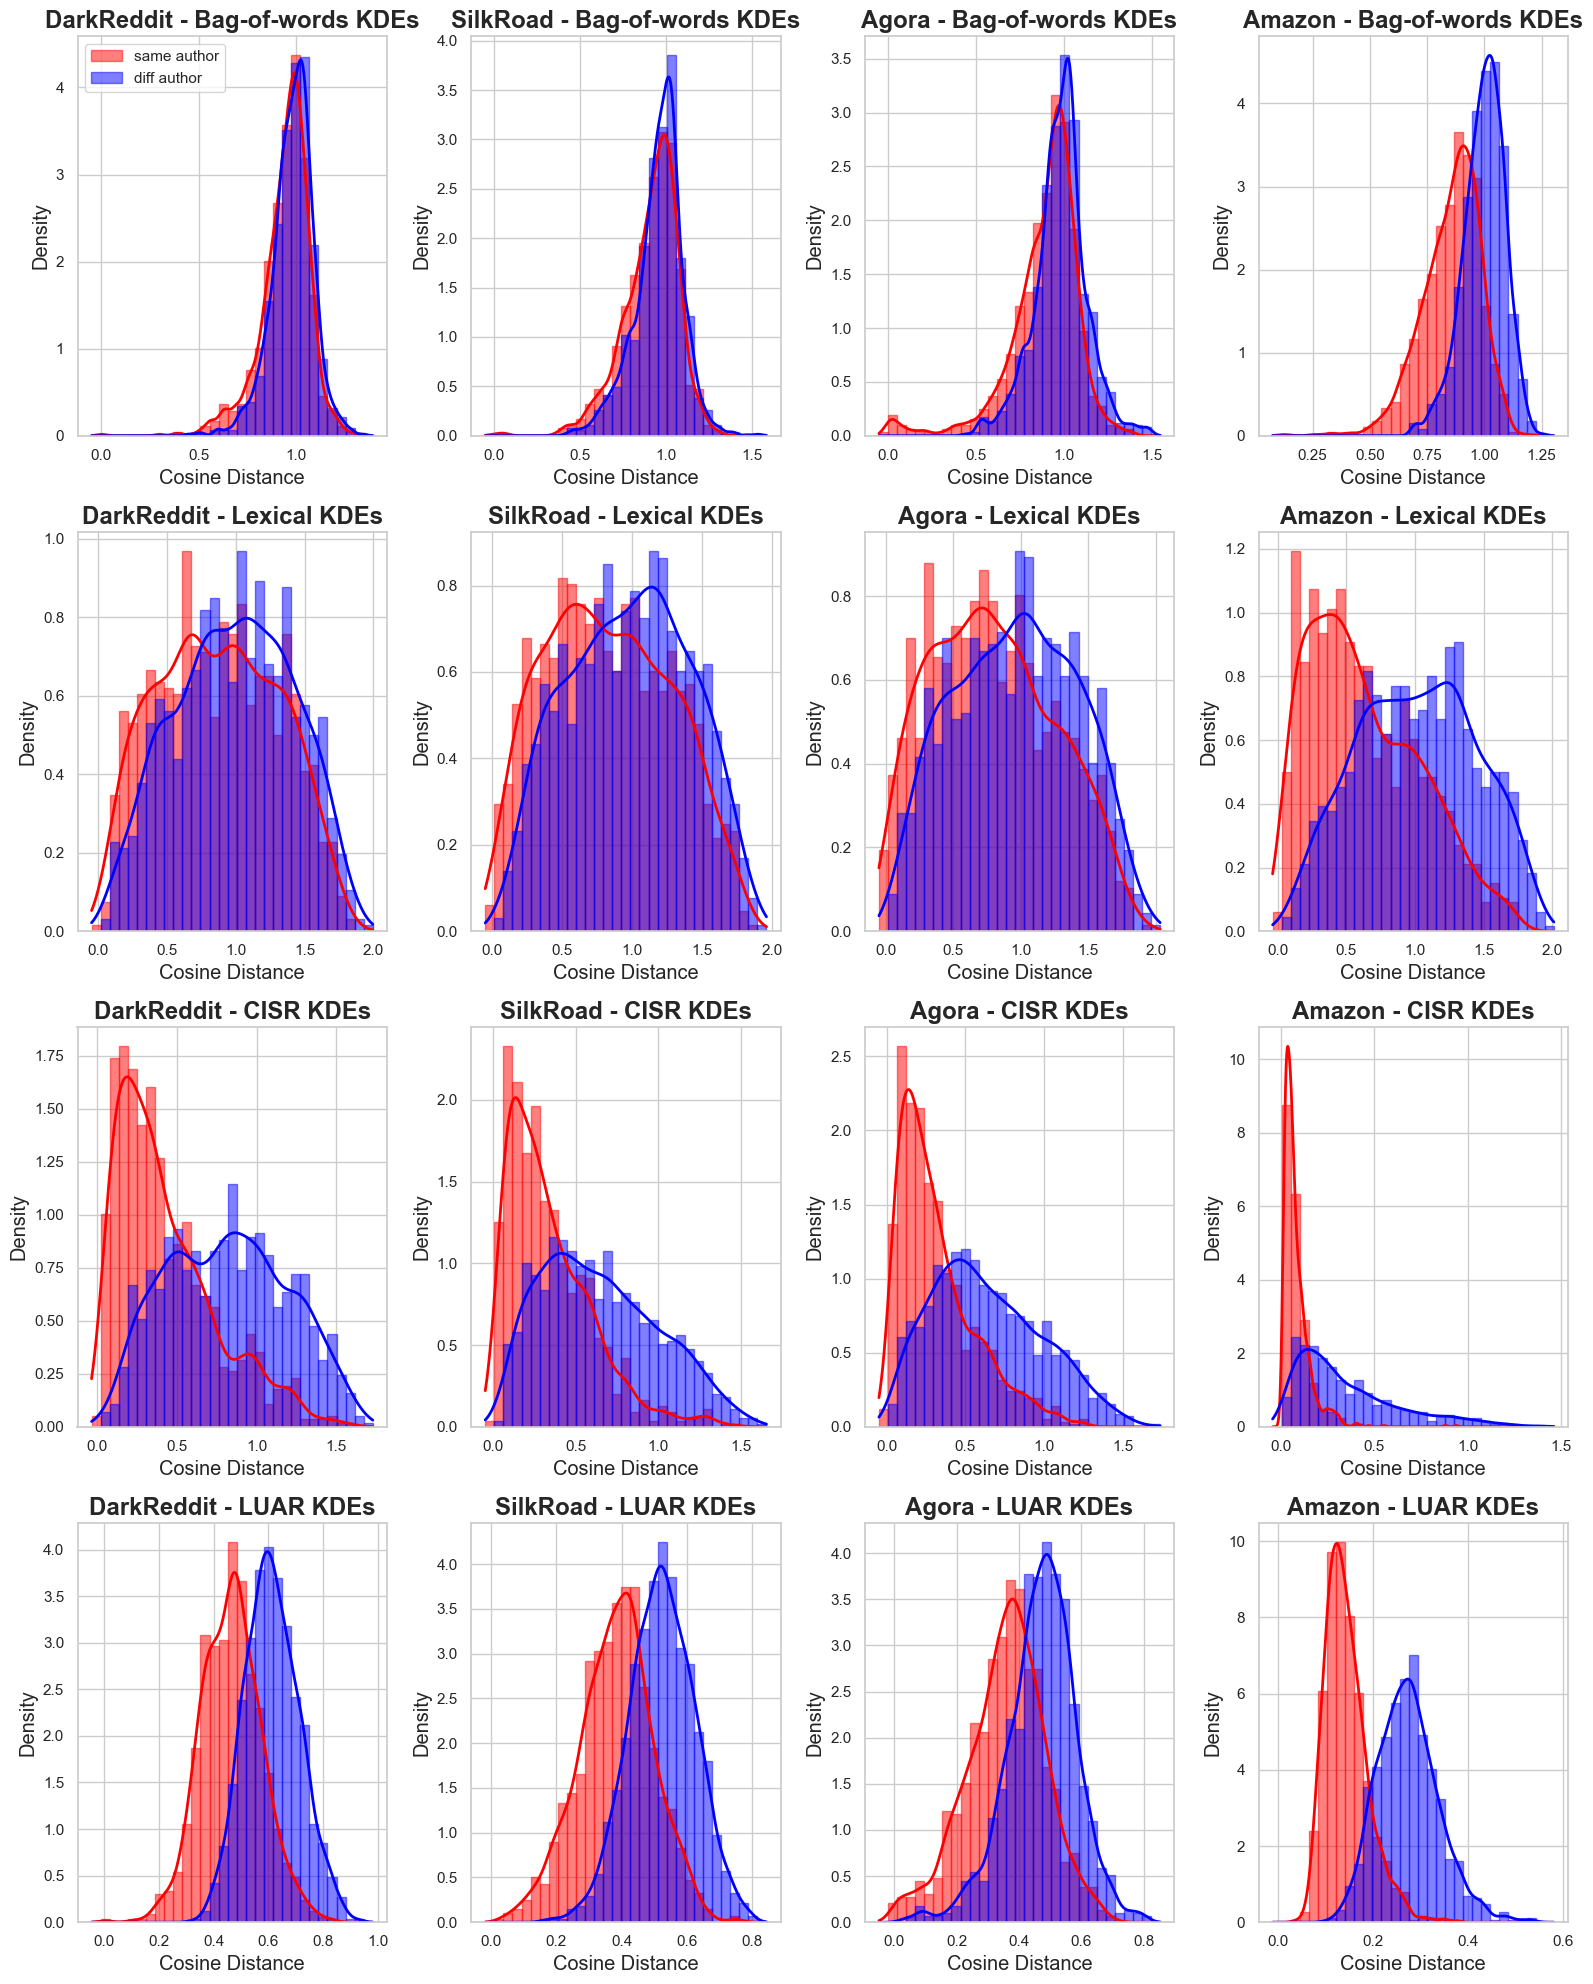

In [43]:
plot_kde_grid(0, close=False)

## AUC Boxplots

In [25]:
sns.set(style='whitegrid')

In [62]:
def plot_auc_boxplot_points(ax, data, title, avg=False, legend=True):
    if avg:
        plot_data = data.loc[data["Method"].isin(['luar_avg_lr', 'cisr_avg_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]
    else:
        plot_data = data.loc[data["Method"].isin(['luar_tru_lr', 'cisr_tru_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]

    sns.boxplot(data=plot_data, x="Method", y="AUC", hue="Category", ax=ax, boxprops={"alpha": 0.5})
    sns.stripplot(data=plot_data, x="Method", y="AUC", hue="Category", ax=ax)
    ax.set_ylim(0.5, 1)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["LUAR", "CISR", "BoW", "Lexical", "Multinomial"])
    ax.set_xlabel("Method", fontweight="bold")
    ax.set_ylabel("AUC", fontweight="bold")
    ax.set_title(title, fontweight="bold", size="large")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=["embedding", "manual"],
            loc='upper right', handlelength=4,
            handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)}) # puts points/color on same legend
    if not legend:
        ax.get_legend().remove()


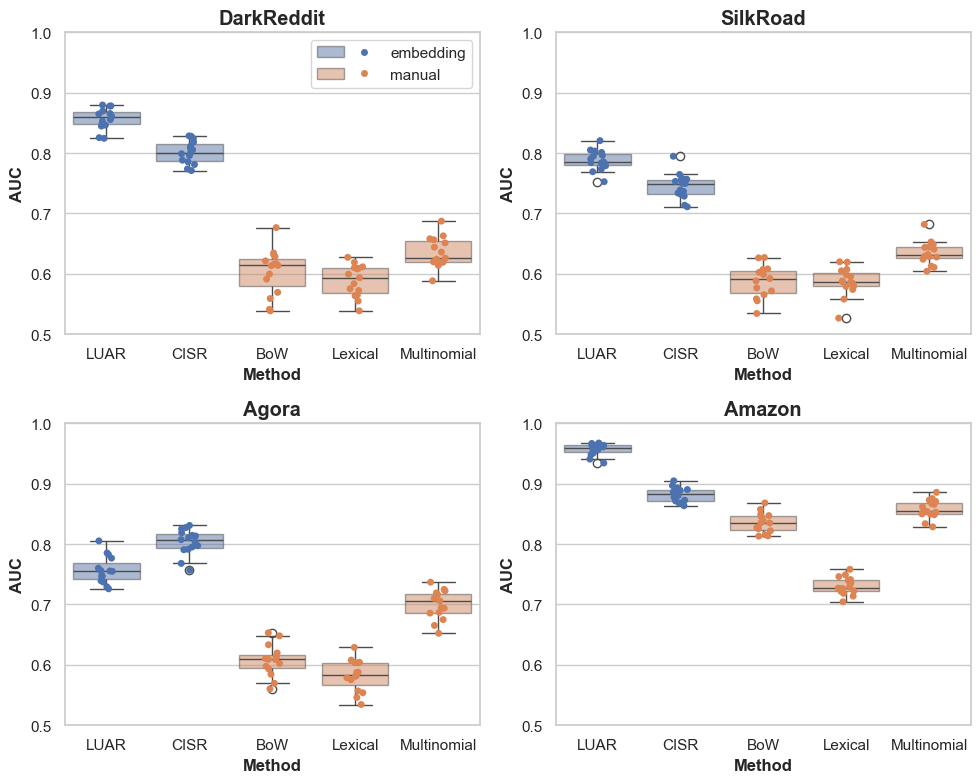

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plot_auc_boxplot_points(ax[0,0], dr, "DarkReddit")
plot_auc_boxplot_points(ax[0,1], sr, "SilkRoad", legend=False)
plot_auc_boxplot_points(ax[1,0], ag, "Agora", legend=False)
plot_auc_boxplot_points(ax[1,1], am, "Amazon", avg=True, legend=False)
plt.tight_layout()
fig.savefig("./figs/auc_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

## Log-likelihood Ratio Cost Tables

In [28]:
def create_cllr_table():
    summary_df_list = []
    datasets = ["DarkReddit", "Agora", "SilkRoad", "Amazon"]
    dfs = [dr, ag, sr, am]
    for i in range(len(dfs)):
        df = dfs[i]
        cllr_summary = df.groupby('Method').agg({'Cllr': ['min', 'max', 'mean']}).loc[:, "Cllr"].reset_index()
        cllr_summary["table_val"] = cllr_summary.round(2).loc[:, "mean"].astype(str) + " (" + cllr_summary.round(2).loc[:, "min"].astype(str) + ", " + cllr_summary.round(2).loc[:, "max"].astype(str) + ")"
        cllr_summary["dataset"] = datasets[i]
        summary_df_list.append(cllr_summary)

    return pd.concat(summary_df_list)

In [29]:
full_cllr_table = create_cllr_table().pivot(index="Method", columns="dataset", values="table_val").reset_index().loc[:, ["Method", "DarkReddit", "SilkRoad", "Agora", "Amazon"]]
full_cllr_table

dataset,Method,DarkReddit,SilkRoad,Agora,Amazon
0,cisr_avg_lr,"0.78 (0.74, 0.83)","0.86 (0.8, 0.91)","0.8 (0.76, 0.86)","1.22 (0.56, 5.49)"
1,cisr_tru_lr,"0.79 (0.75, 0.83)","0.86 (0.81, 0.91)","0.78 (0.75, 0.85)","0.77 (0.68, 1.02)"
2,count_lr,"1.56 (1.29, 1.83)","2.03 (1.64, 2.28)","1.96 (1.66, 2.87)","8.33 (7.18, 9.38)"
3,lex_lr,"0.97 (0.96, 1.0)","0.98 (0.97, 1.0)","0.98 (0.96, 1.0)","0.88 (0.85, 0.91)"
4,luar_avg_lr,"0.68 (0.63, 0.74)","0.8 (0.75, 0.86)","0.86 (0.79, 0.89)","0.39 (0.34, 0.46)"
5,luar_tru_lr,"0.68 (0.63, 0.74)","0.8 (0.75, 0.85)","0.85 (0.78, 0.89)","0.5 (0.46, 0.56)"
6,luar_win_lr,"0.76 (0.7, 0.82)","0.86 (0.8, 0.96)","0.84 (0.78, 0.89)","0.59 (0.54, 0.65)"
7,znorm_lr,"0.97 (0.92, 1.06)","0.99 (0.97, 1.05)","0.98 (0.94, 1.01)","0.73 (0.67, 0.79)"


In [30]:
print(full_cllr_table.style.hide().to_latex(convert_css=True))

\begin{tabular}{lllll}
Method & DarkReddit & SilkRoad & Agora & Amazon \\
cisr_avg_lr & 0.78 (0.74, 0.83) & 0.86 (0.8, 0.91) & 0.8 (0.76, 0.86) & 1.22 (0.56, 5.49) \\
cisr_tru_lr & 0.79 (0.75, 0.83) & 0.86 (0.81, 0.91) & 0.78 (0.75, 0.85) & 0.77 (0.68, 1.02) \\
count_lr & 1.56 (1.29, 1.83) & 2.03 (1.64, 2.28) & 1.96 (1.66, 2.87) & 8.33 (7.18, 9.38) \\
lex_lr & 0.97 (0.96, 1.0) & 0.98 (0.97, 1.0) & 0.98 (0.96, 1.0) & 0.88 (0.85, 0.91) \\
luar_avg_lr & 0.68 (0.63, 0.74) & 0.8 (0.75, 0.86) & 0.86 (0.79, 0.89) & 0.39 (0.34, 0.46) \\
luar_tru_lr & 0.68 (0.63, 0.74) & 0.8 (0.75, 0.85) & 0.85 (0.78, 0.89) & 0.5 (0.46, 0.56) \\
luar_win_lr & 0.76 (0.7, 0.82) & 0.86 (0.8, 0.96) & 0.84 (0.78, 0.89) & 0.59 (0.54, 0.65) \\
znorm_lr & 0.97 (0.92, 1.06) & 0.99 (0.97, 1.05) & 0.98 (0.94, 1.01) & 0.73 (0.67, 0.79) \\
\end{tabular}



In [58]:
def plot_cllr_boxplot_points(ax, data, title, ymin=0, ymax=2, avg=False, legend=True):
    if avg:
        plot_data = data.loc[data["Method"].isin(['luar_avg_lr', 'cisr_avg_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]
    else:
        plot_data = data.loc[data["Method"].isin(['luar_tru_lr', 'cisr_tru_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]

    sns.boxplot(data=plot_data, x="Method", y="Cllr", hue="Category", ax=ax, boxprops={"alpha": 0.5})
    sns.stripplot(data=plot_data, x="Method", y="Cllr", hue="Category", ax=ax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["LUAR", "CISR", "BoW", "Lexical", "Multinomial"])
    ax.set_xlabel("Method", fontweight="bold")
    ax.set_ylabel("Cllr", fontweight="bold")
    ax.set_title(title, fontweight="bold", size="large")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=["embedding", "manual"],
            loc='best', handlelength=4,
            handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)}) # puts points/color on same legend
    if not legend:
        ax.get_legend().remove()

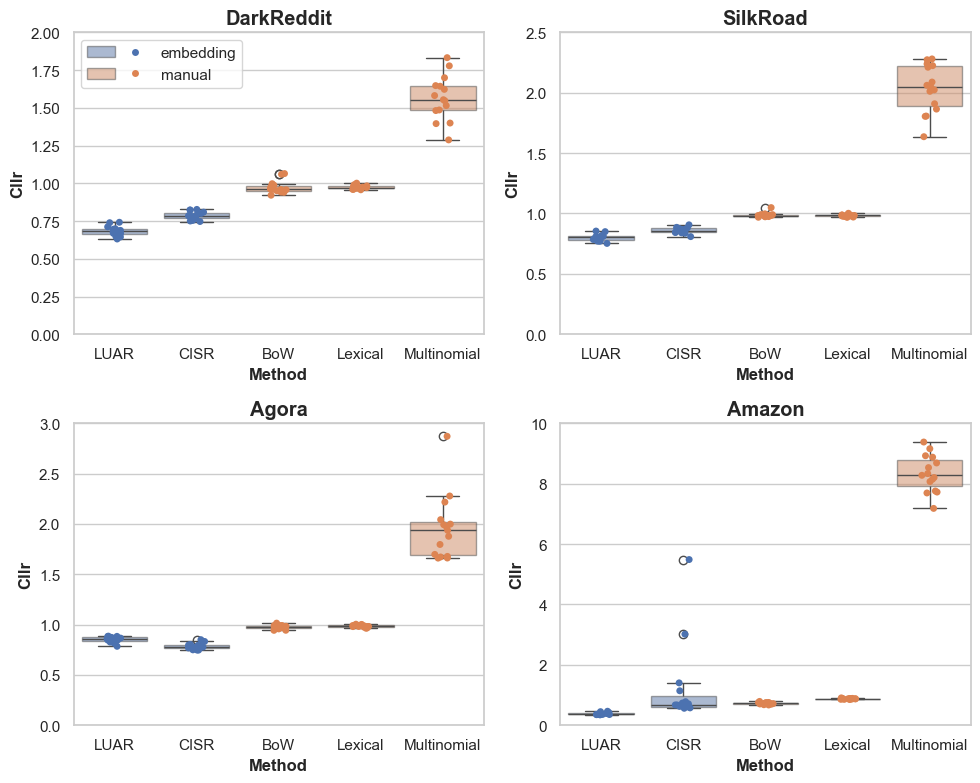

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plot_cllr_boxplot_points(ax[0,0], dr, "DarkReddit")
plot_cllr_boxplot_points(ax[0,1], sr, "SilkRoad", ymax=2.5, legend=False)
plot_cllr_boxplot_points(ax[1,0], ag, "Agora", ymax=3, legend=False)
plot_cllr_boxplot_points(ax[1,1], am, "Amazon", avg=True, ymax=10, legend=False)
plt.tight_layout()
fig.savefig("./figs/cllr_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

## Tippett Plots

In [53]:
def plot_tippett_plots(dataset, avg=False, x=2, mn_x=2):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    test_files = ['./results/' + dataset + '_test' + str(i) + '.csv' for i in range(15)]
    if avg:
        methods = ["luar_avg_lr", "cisr_avg_lr", "znorm_lr", "lex_lr", "count_lr"]
    else:
        methods = ["luar_tru_lr", "cisr_tru_lr", "znorm_lr", "lex_lr", "count_lr"]

    plot_methods = ["LUAR", "CISR", "Bag of Words", "Lexical", "Multinomial"]
    method_rows = [0, 1]*3 
    method_cols = [0]*2 + [1]*2 + [2]*2

    for k in range(len(methods)):
        for f in test_files:
            lr_results = pd.read_csv(f)
            if methods[k] == "count_lr": # multinomial on ln scale
                lr_results["log10" + methods[k]] = lr_results.loc[:, [methods[k]]].transform(lambda x: x / np.log(10))
            else:
                lr_results["log10" + methods[k]] = lr_results.loc[:, [methods[k]]].transform(lambda x: np.log(x) / np.log(10))
            sns.ecdfplot(data=lr_results, 
                         x="log10" + methods[k], 
                         hue="same_source", 
                         complementary=True, 
                         linewidth=1.5, 
                         palette={True: "red", False: "blue"}, 
                         alpha=0.3, 
                         ax=ax[method_rows[k], method_cols[k]])
        if methods[k] == "count_lr":
            ax[method_rows[k], method_cols[k]].set_xlim(-mn_x, mn_x)
        else:
            ax[method_rows[k], method_cols[k]].set_xlim(-x, x)
        ax[method_rows[k], method_cols[k]].axvline(0, color='black', linestyle="--", linewidth=2.5)
        ax[method_rows[k], method_cols[k]].set_xlabel("Log10(LR) Greater Than", fontweight="bold")
        ax[method_rows[k], method_cols[k]].set_ylabel("Proportion", fontweight="bold")
        ax[method_rows[k], method_cols[k]].get_legend().remove()
        ax[method_rows[k], method_cols[k]].set_title(plot_methods[k], fontweight="bold", size="large")
        ax[method_rows[k], method_cols[k]].set_ylim(-0.1, 1)
    
    ax[0, 0].legend(["same author", "diff author"], loc="best")
    ax[1, 2].axis("off")
    plt.tight_layout()
    fig.savefig("./figs/" + dataset + "-tippett.png", dpi=300, bbox_inches="tight")
    plt.show()

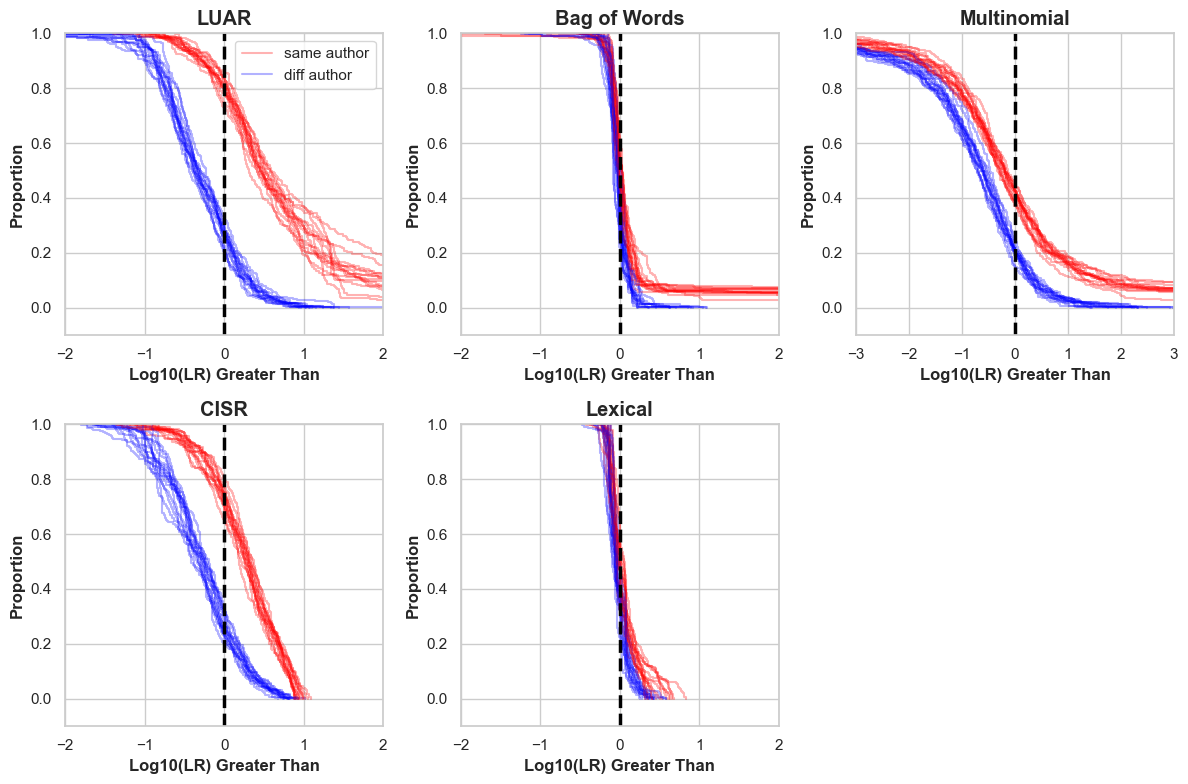

In [54]:
plot_tippett_plots("darkreddit", mn_x=3)

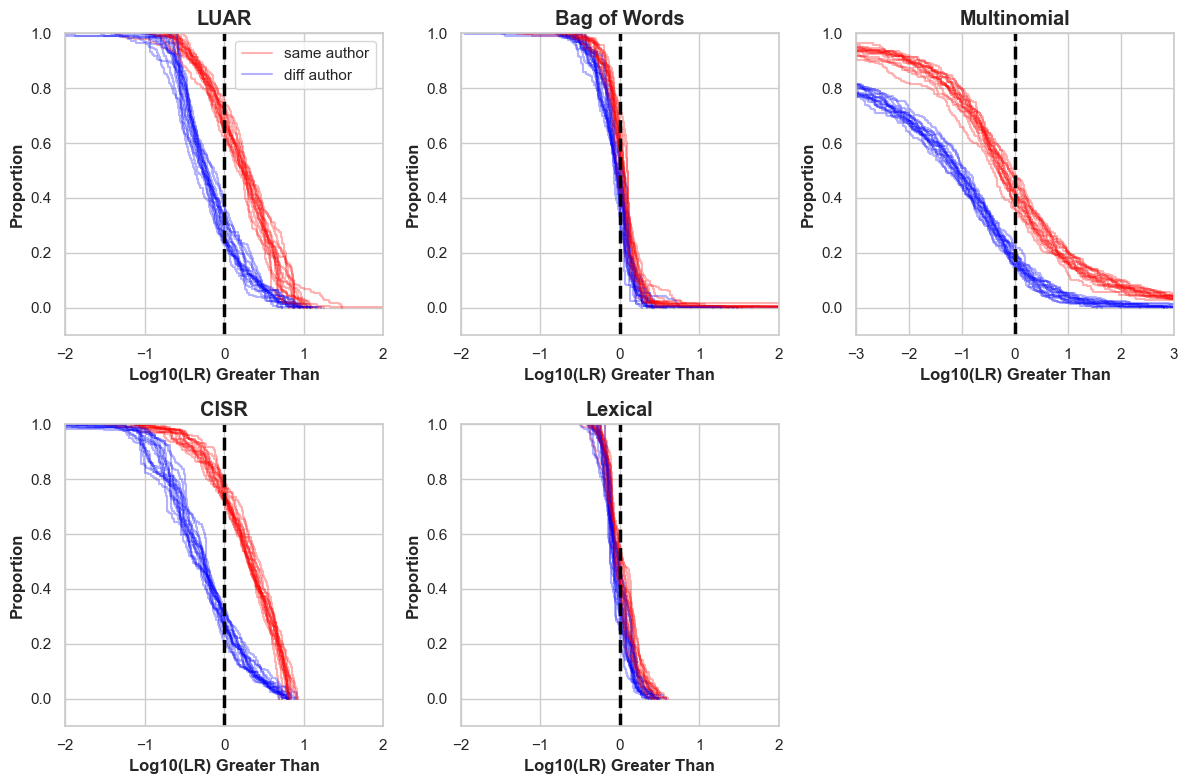

In [55]:
plot_tippett_plots("agora", mn_x=3)

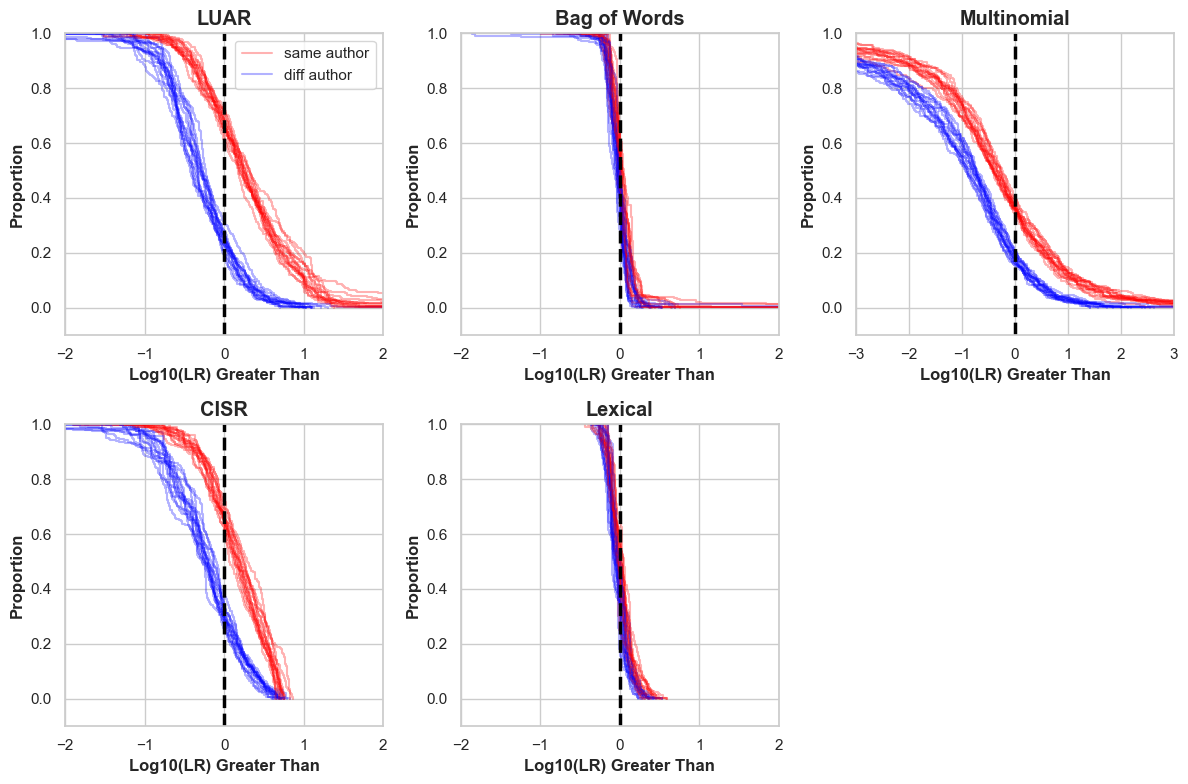

In [56]:
plot_tippett_plots("silkroad", mn_x=3)

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


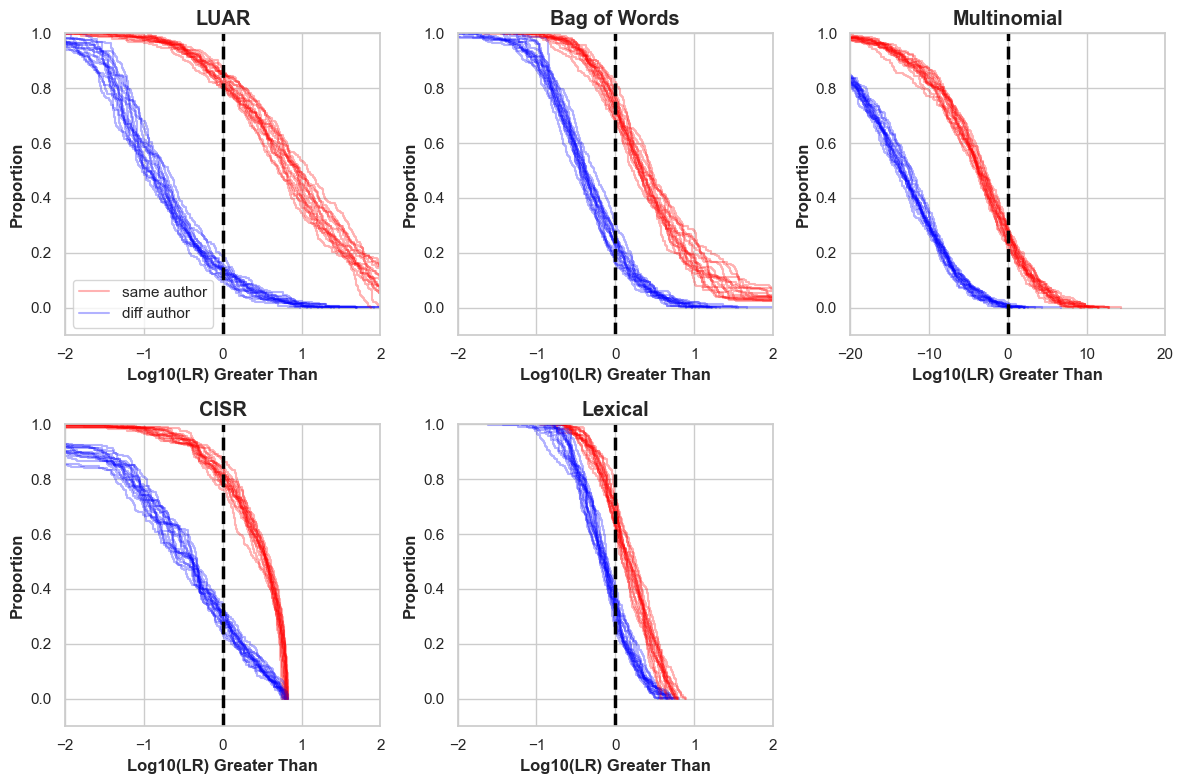

In [57]:
plot_tippett_plots("amazon", mn_x=20) # runtime warnings because of numerical underflow w Amazon dataset (some LR ~= 0)